hx=0.2, hz=0.01
hx=0.2, hz=0.05
hx=0.2, hz=0.1
hx=0.2, hz=0.2
hx=0.2, hz=0.30000000000000004
hx=0.2, hz=0.4
hx=0.2, hz=0.5
hx=0.2, hz=0.6
hx=0.2, hz=0.7000000000000001
hx=0.2, hz=0.8
hx=0.2, hz=0.9
hx=0.2, hz=1.0
hx=0.2, hz=1.1
hx=0.2, hz=1.2000000000000002
hx=0.2, hz=1.3000000000000003
hx=0.2, hz=1.4000000000000001
hx=0.2, hz=1.5000000000000002
hx=0.2, hz=1.6
hx=0.2, hz=1.7000000000000002
hx=0.2, hz=1.8000000000000003
hx=0.2, hz=1.9000000000000001
hx=0.2, hz=2.0
hx=0.2, hz=2.1
hx=0.2, hz=2.2
hx=0.2, hz=2.3000000000000003
hx=0.2, hz=2.4000000000000004
hx=0.2, hz=2.5000000000000004
hx=0.2, hz=2.6
hx=0.2, hz=2.7
hx=0.2, hz=2.8000000000000003
hx=0.2, hz=2.9000000000000004
hx=0.2, hz=3.0000000000000004
hx=0.2, hz=3.1
hx=0.2, hz=3.2
hx=0.2, hz=3.3000000000000003
hx=0.2, hz=3.4000000000000004
hx=0.2, hz=3.5000000000000004
hx=0.2, hz=3.6
hx=0.2, hz=3.7
hx=0.2, hz=3.8000000000000003
hx=0.2, hz=3.9000000000000004
hx=0.2, hz=4.0
hx=0.2, hz=4.1
hx=0.2, hz=4.2
hx=0.2, hz=4.3
hx=0.2, hz=4.399999999

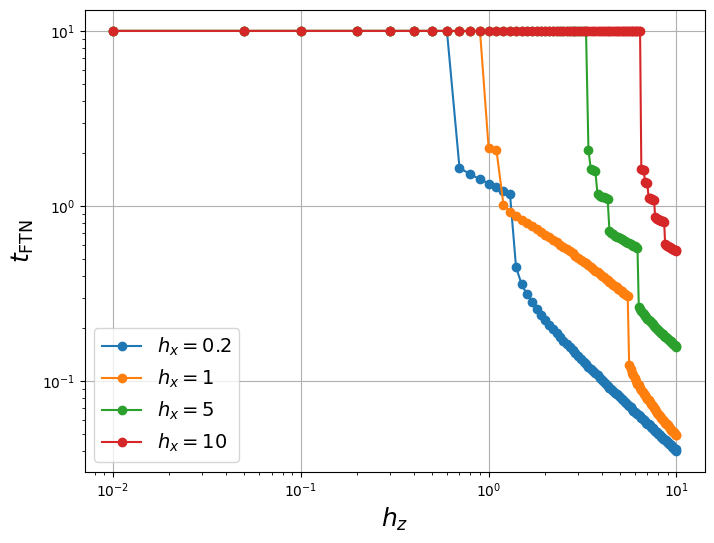

In [4]:
import numpy as np
from scipy.linalg import expm, eigh
from numpy import kron
import matplotlib.pyplot as plt
import time

# ===========================
#  Pauli matrices
# ===========================
sx = np.array([[0,1],[1,0]],dtype=complex)
sy = np.array([[0,-1j],[1j,0]],dtype=complex)
sz = np.array([[1,0],[0,-1]],dtype=complex)
id2 = np.eye(2,dtype=complex)

# ===========================
#  Kronecker embedding
# ===========================
def embed(op, site, N):
    """Embed single-site operator op at position site (1-indexed)."""
    ops = [op if i==site else id2 for i in range(1, N+1)]
    M = ops[0]
    for k in range(1, N):
        M = kron(M, ops[k])
    return M

# ===========================
#  TFIM Hamiltonian
# ===========================
def TFIM(N, J, hz, hx):
    Hxx = np.zeros((2**N,2**N),dtype=complex)
    Hz  = np.zeros((2**N,2**N),dtype=complex)
    Hx  = np.zeros((2**N,2**N),dtype=complex)

    for i in range(1,N):
        Hxx += embed(sx,i,N) @ embed(sx,i+1,N)

    for i in range(1,N+1):
        Hz += embed(sz,i,N)
        Hx += embed(sx,i,N)

    H = -J*Hxx - hz*Hz - hx*Hx
    return H, Hxx, Hz, Hx


# ===========================
#  Projectors (Z-basis)
# ===========================
zu = np.array([[1],[0]],dtype=complex)
zd = np.array([[0],[1]],dtype=complex)
Pzu = zu @ zu.conj().T
Pzd = zd @ zd.conj().T

def PZu(i): return embed(Pzu, i, N)
def PZd(i): return embed(Pzd, i, N)

# ===========================
#  Projectors (X-basis)
# ===========================
xu = np.array([[1],[1]],dtype=complex) / np.sqrt(2)
xd = np.array([[1],[-1]],dtype=complex) / np.sqrt(2)

Pxu = xu @ xu.conj().T
Pxd = xd @ xd.conj().T

def PXu(i): return embed(Pxu, i, N)
def PXd(i): return embed(Pxd, i, N)


# ============================================================
#  PARAMETERS
# ============================================================
L = 4
N = L
J = 1

hx_list = [0.2, 1, 5, 10]
hz_list = [0.01, 0.05] + list(np.arange(0.1, 10.1, 0.1))

dt = 0.001
T1, T2 = 0, 10
tt = np.arange(T1, T2+dt, dt)

plt.figure(figsize=(8,6))

# ============================================================
#  MAIN LOOP (hx, hz)
# ============================================================
for hx in hx_list:
    tl = []   # FTN times

    for hz in hz_list:
        print(f"hx={hx}, hz={hz}")

        # Build Hamiltonian
        H, Hxx, Hz_mat, Hx_mat = TFIM(N, J, hz, hx)

        # Ground state
        eigvals, eigvecs = eigh(H)
        S0 = eigvecs[:, np.argmin(eigvals)]

        # Projectors
        #V1, V2 = PXu(1), PXd(1)
        #W1, W2 = PXu(1), PXd(1)
        V1, V2 = PZu(1), PZd(1)
        W1, W2 = PZu(2), PZd(2)

        # Time evolution
        thx = T2  # default FTN time

        for ti, t in enumerate(tt):
            U = expm(-1j*H*t)

            PP = 0
            for i in [1,2]:
                for j in [1,2]:
                    if i==1 and j==1: V, W = V1, W1
                    elif i==1 and j==2: V, W = V1, W2
                    elif i==2 and j==1: V, W = V2, W1
                    else:              V, W = V2, W2

                    Vt = U.conj().T @ V @ U
                    P = np.abs(np.real(S0.conj().T @ Vt @ W @ S0))
                    PP += P

            Ne = PP - 1

            if Ne > 1e-8:
                thx = t
                break

        tl.append(thx)

    # Plot for this hx
    plt.plot(hz_list, tl, '-o', label=f"$h_x={hx}$")

# ============================================================
# Plot formatting
# ============================================================
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$h_z$", fontsize=18)
plt.ylabel(r"$t_{\rm FTN}$", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()
